In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime

In [2]:
class Config:
    pass
config = pd.read_pickle('config.pkl')

In [3]:
data_path = '../../kaggleData/JD_logging/'
feature_path = '../../kaggleData/JD_logging/features/'

In [4]:
login_tt = pd.read_csv(data_path+'login_tt.csv')
#trade_tt = pd.read_csv(data_path+'trade_tt.csv')

In [5]:
login_tt['time'] = login_tt['time'].apply(lambda x : datetime.datetime.strptime(x , '%Y-%m-%d %H:%M:%S'))
#trade_tt['time'] = trade_tt['time'].apply(lambda x : datetime.datetime.strptime(x , '%Y-%m-%d %H:%M:%S'))

In [6]:
#login_tt['time'] = login_tt['time'].apply(lambda x : datetime.datetime.strptime(x , '%Y-%m-%d %H:%M:%S'))

#login time generating and building cycles
login_tt['month'] = login_tt['time'].apply(lambda x : x.month)
login_tt['day'] = login_tt['time'].apply(lambda x : x.day)
login_tt['weekday'] = login_tt['time'].apply(lambda x : x.weekday())
login_tt['hour'] = login_tt['time'].apply(lambda x : x.hour)

#login_tt['month_cycle'] = login_tt['month'].apply(lambda x : x + 6 if x + 6 < 12 else x-6)
login_tt['day_cycle'] = login_tt['day'].apply(lambda x : x+15 if x + 15< 31 else x - 15)
login_tt['weekday_cycle'] = login_tt['weekday'].apply(lambda x : x+3 if x +3 < 7 else x -3)
login_tt['hour_cycle'] = login_tt['hour'].apply(lambda x : x + 12 if x + 12 < 23 else x - 12)

"""
#trade time generating and building cycles
trade_tt['month'] = trade_tt['time'].apply(lambda x : x.month)
trade_tt['day'] = trade_tt['time'].apply(lambda x : x.day)
trade_tt['weekday'] = trade_tt['time'].apply(lambda x : x.weekday())
trade_tt['hour'] = trade_tt['time'].apply(lambda x : x.hour)

#trade_tt['month_cycle'] = trade_tt['month'].apply(lambda x : x + 6 if x + 6 < 12 else x-6)
trade_tt['day_cycle'] = trade_tt['day'].apply(lambda x : x+15 if x + 15< 31 else x - 15)
trade_tt['weekday_cycle'] = trade_tt['weekday'].apply(lambda x : x+3 if x +3 < 7 else x -3)
trade_tt['hour_cycle'] = trade_tt['hour'].apply(lambda x : x + 12 if x + 12 < 23 else x - 12)

"""

"\n#trade time generating and building cycles\ntrade_tt['month'] = trade_tt['time'].apply(lambda x : x.month)\ntrade_tt['day'] = trade_tt['time'].apply(lambda x : x.day)\ntrade_tt['weekday'] = trade_tt['time'].apply(lambda x : x.weekday())\ntrade_tt['hour'] = trade_tt['time'].apply(lambda x : x.hour)\n\n#trade_tt['month_cycle'] = trade_tt['month'].apply(lambda x : x + 6 if x + 6 < 12 else x-6)\ntrade_tt['day_cycle'] = trade_tt['day'].apply(lambda x : x+15 if x + 15< 31 else x - 15)\ntrade_tt['weekday_cycle'] = trade_tt['weekday'].apply(lambda x : x+3 if x +3 < 7 else x -3)\ntrade_tt['hour_cycle'] = trade_tt['hour'].apply(lambda x : x + 12 if x + 12 < 23 else x - 12)\n\n"

In [7]:
def find_related_logins_before(row,login_table,*args,**kw):
    related_logins = login_table[login_table['id'] == row.id]
    related_logins_before = related_logins[related_logins['time']<row.time]
    return related_logins_before

#when times is larger than all related login times, no errors return but only returning all past related ones, no null rows filled 
def related_logins_by_time(row,login_table,times):
    related_logins_before = find_related_logins_before(row,login_table).sort_values(by = 'time',ascending = False)
    return related_logins_before[:times]

### finding the last logins

In [8]:
"""
#trade_tt['recent_login_id'] = trade_tt.apply(lambda x : list(related_logins_by_time(x ,login_tt,3)['log_id']),axis=1)
temp = []
for row_tuple in trade_tt.iterrows():
    row = row_tuple[1]
    temp.append(related_logins_by_time(row ,login_tt,3)['log_id'])
    
trade_tt['recent_login_id'] = temp

trade_tt['recent_login_id_0'] = trade_tt['recent_login_id'].apply(lambda x : x.iloc[0] if len(x)>0 else None)
trade_tt['recent_login_id_1'] = trade_tt['recent_login_id'].apply(lambda x : x.iloc[1] if len(x)>1 else None)
trade_tt['recent_login_id_2'] = trade_tt['recent_login_id'].apply(lambda x : x.iloc[2] if len(x)>2 else None)

del trade_tt['recent_login_id']
"""
#trade_tt.to_csv(data_path+'trade_tt_with_recent_3_log_id.csv',index =False)
trade_tt = pd.read_csv(data_path+'trade_tt_with_recent_3_log_id.csv')
trade_tt['time'] = trade_tt['time'].apply(lambda x : datetime.datetime.strptime(x , '%Y-%m-%d %H:%M:%S'))

### Making up additional detail information

In [9]:
trade_tt['recent_login_number'] = trade_tt.apply(lambda x : 3 if not pd.isnull(x.recent_login_id_2)  else 2 if not pd.isnull(x.recent_login_id_1)
                                                else 1 if not pd.isnull(x.recent_login_id_0) else 0, axis =1)

In [14]:
#regenerated 
login_tt['has_trade'] = np.isnan(login_tt.merge(trade_tt,how = 'left',left_on = 'log_id',
right_on = 'recent_login_id_0',suffixes = ['','_trade'])['recent_login_id_0'])

### Combining the login info to the trade table  

In [14]:
detail_info = ['timelong','log_from','city','result','type','is_scan',
               'month','day','weekday','hour','day_cycle','weekday_cycle','hour_cycle','has_trade']

In [15]:
login_tt_detail = login_tt[['log_id','time','device','ip']+detail_info]

In [18]:
#merging
trade_tt = trade_tt.merge(login_tt_detail.add_suffix('_login_0'),how = 'left',left_on ='recent_login_id_0',right_on = 'log_id_login_0',
                          copy = False)
trade_tt = trade_tt.merge(login_tt_detail.add_suffix('_login_1'),how = 'left',left_on ='recent_login_id_1',right_on = 'log_id_login_1',
                         copy = False)
trade_tt = trade_tt.merge(login_tt_detail.add_suffix('_login_2'),how = 'left',left_on ='recent_login_id_2',right_on = 'log_id_login_2',
                          copy = False)

In [17]:
#getting the time distance 
trade_tt['login_distance_0']=trade_tt['time']-trade_tt['time_login_0']
trade_tt['login_distance_1']=trade_tt['time']-trade_tt['time_login_1']
trade_tt['login_distance_2']=trade_tt['time']-trade_tt['time_login_2']

In [34]:
#getting if using the same device/ip
suffixes = ['_login_1','_login_2']
comparings = ['device','ip','city','log_from','result','type']

comparing_result = []

for comparing in comparings:
    for suffix in suffixes:
        print(comparing,suffix)
        trade_tt[comparing+'_comparing'+suffix] = (trade_tt[comparing+'_login_0']==trade_tt[comparing+suffix])
        comparing_result.append(comparing+'_comparing'+suffix)
        
comparing_result.extend(['login_distance_0','login_distance_1','login_distance_2'])

('device', '_login_1')
('device', '_login_2')
('ip', '_login_1')
('ip', '_login_2')
('city', '_login_1')
('city', '_login_2')
('log_from', '_login_1')
('log_from', '_login_2')
('result', '_login_1')
('result', '_login_2')
('type', '_login_1')
('type', '_login_2')


In [36]:
trade_tt.columns

Index([u'rowkey', u'time', u'id', u'from', u'month', u'day', u'weekday',
       u'hour', u'day_cycle', u'weekday_cycle', u'hour_cycle',
       u'recent_login_id_0', u'recent_login_id_1', u'recent_login_id_2',
       u'recent_login_number', u'log_id_login_0', u'time_login_0',
       u'device_login_0', u'ip_login_0', u'timelong_login_0',
       u'log_from_login_0', u'city_login_0', u'result_login_0',
       u'type_login_0', u'is_scan_login_0', u'month_login_0', u'day_login_0',
       u'weekday_login_0', u'hour_login_0', u'day_cycle_login_0',
       u'weekday_cycle_login_0', u'hour_cycle_login_0', u'log_id_login_1',
       u'time_login_1', u'device_login_1', u'ip_login_1', u'timelong_login_1',
       u'log_from_login_1', u'city_login_1', u'result_login_1',
       u'type_login_1', u'is_scan_login_1', u'month_login_1', u'day_login_1',
       u'weekday_login_1', u'hour_login_1', u'day_cycle_login_1',
       u'weekday_cycle_login_1', u'hour_cycle_login_1', u'log_id_login_2',
       u'time_log

### building the basic detail feature set

In [38]:
trade_detail = ['month','day','weekday','hour','day_cycle','weekday_cycle','hour_cycle']

login_detail = []
suffixes = ['_login_0','_login_1','_login_2']
for detail in detail_info:
    for suffix in suffixes:
        login_detail.append(detail+suffix)
    
trade_basic = trade_tt[trade_detail+login_detail+comparing_result+['recent_login_number']]

## data cleaning

### Normal int/float cleaning

In [41]:
print trade_basic.columns

Index([u'month', u'day', u'weekday', u'hour', u'day_cycle', u'weekday_cycle',
       u'hour_cycle', u'timelong_login_0', u'timelong_login_1',
       u'timelong_login_2', u'log_from_login_0', u'log_from_login_1',
       u'log_from_login_2', u'city_login_0', u'city_login_1', u'city_login_2',
       u'result_login_0', u'result_login_1', u'result_login_2',
       u'type_login_0', u'type_login_1', u'type_login_2', u'is_scan_login_0',
       u'is_scan_login_1', u'is_scan_login_2', u'month_login_0',
       u'month_login_1', u'month_login_2', u'day_login_0', u'day_login_1',
       u'day_login_2', u'weekday_login_0', u'weekday_login_1',
       u'weekday_login_2', u'hour_login_0', u'hour_login_1', u'hour_login_2',
       u'day_cycle_login_0', u'day_cycle_login_1', u'day_cycle_login_2',
       u'weekday_cycle_login_0', u'weekday_cycle_login_1',
       u'weekday_cycle_login_2', u'hour_cycle_login_0', u'hour_cycle_login_1',
       u'hour_cycle_login_2', u'device_comparing_login_1',
       u'device_

In [42]:
#trade_basic.to_pickle(data_path+'trade_basic_temp.pkl')

In [38]:
#cleaning the data
columns_with_null = []
for column in  trade_basic.columns:
    if np.sum(pd.isnull(trade_basic[column]))>0:
        columns_with_null.append(column)

In [43]:
#fill the N/A values with a new certain mark
#reset the login timelong to be certain minus value as -1
#set all others to be -10,meaning value lost
trade_basic.loc[trade_basic['timelong_login_0']<0,'timelong_login_0'] = -1
trade_basic = trade_basic.fillna(-10)

C:\Users\dell\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Timedelta converting and cleaning

In [80]:
temp = trade_basic['login_distance_0']

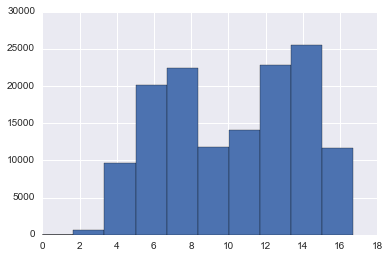

In [99]:
temp[temp == -10] = np.nan
plt.hist(np.log(temp.dropna()))
plt.show()

In [45]:
trade_basic['login_distance_0'] = trade_basic['login_distance_0'].apply(lambda x : np.log(x.total_seconds()))
trade_basic['login_distance_1'] = trade_basic['login_distance_1'].apply(lambda x : np.log(x.total_seconds()))
trade_basic['login_distance_2'] = trade_basic['login_distance_2'].apply(lambda x : np.log(x.total_seconds()))

trade_basic = trade_basic.fillna(-10)

In [48]:
len(trade_basic)

150594

### generating feature set

In [49]:
class Config():
    pass

In [50]:
config = pd.read_pickle('config.pkl')

In [51]:
dir(config)

['__doc__',
 '__module__',
 'data_path',
 'feature_dict',
 'feature_path',
 'trade_train_size']

In [53]:
#config.feature_dict = {}
config.feature_dict['trade_detail_feature'] = trade_detail
config.feature_dict['recent_login_detail'] = login_detail+['recent_login_number']
config.feature_dict['trade_and_recent_login_comparing'] = comparing_result

In [54]:
pd.to_pickle(config,'config.pkl')

In [55]:
trade_basic.columns

Index([u'month', u'day', u'weekday', u'hour', u'day_cycle', u'weekday_cycle',
       u'hour_cycle', u'timelong_login_0', u'timelong_login_1',
       u'timelong_login_2', u'log_from_login_0', u'log_from_login_1',
       u'log_from_login_2', u'city_login_0', u'city_login_1', u'city_login_2',
       u'result_login_0', u'result_login_1', u'result_login_2',
       u'type_login_0', u'type_login_1', u'type_login_2', u'is_scan_login_0',
       u'is_scan_login_1', u'is_scan_login_2', u'month_login_0',
       u'month_login_1', u'month_login_2', u'day_login_0', u'day_login_1',
       u'day_login_2', u'weekday_login_0', u'weekday_login_1',
       u'weekday_login_2', u'hour_login_0', u'hour_login_1', u'hour_login_2',
       u'day_cycle_login_0', u'day_cycle_login_1', u'day_cycle_login_2',
       u'weekday_cycle_login_0', u'weekday_cycle_login_1',
       u'weekday_cycle_login_2', u'hour_cycle_login_0', u'hour_cycle_login_1',
       u'hour_cycle_login_2', u'device_comparing_login_1',
       u'device_

In [57]:
trade_basic.to_pickle(data_path+'trade_basic_and_recent_login.pkl')

In [58]:
for feature in list(trade_basic.columns):
    pd.to_pickle(trade_basic[feature].values,feature_path+feature+'.pkl')